In [ ]:
#pip install pyspark

In [ ]:
#sudo su 
#apt-get update
#apt-get install openjdk-8-jdk-headless -qq > /dev/null 
#wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
#tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [1]:
#Importing libraries
from pyspark.sql import SparkSession, SQLContext
import pyspark
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.sql.functions import log
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import math

import os

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
#Setting environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.1-bin-hadoop3.2"

In [3]:
#Creating Spark session
spark = SparkSession \
    .builder \
    .appName("PySpark App") \
    .config("spark.jars", "jar_files/postgresql-42.3.2.jar") \
    .getOrCreate()
spark

In [4]:
#Creating Spark and SQL context
sparkcontext = pyspark.SparkContext.getOrCreate()
sqlcontext = SQLContext(sparkcontext)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
#Importing data
df = pd.read_csv("output_data/data_vf.csv", index_col = 0)
df_spark = spark.createDataFrame(df)
df_spark_reduced = spark.createDataFrame(df)

In [6]:
#Creating dataset variables overview
columns = df.columns
description = ["Type of dwelling",
               "Number of bedrooms",
               "Number of bathrooms",
               "Distance from rental to the nearest station",
               "Address",
               "Rent",
               "Postcode",
               "(Imputed) size",
               "Source of listing",
               "Postcode latitude",
               "Postcode longitude",
               "Share of postcode population aged < 16",
               "Share of postcode population aged 16-29",
               "Share of postcode population aged 30-44",
               "Share of postcode population aged 45-65",
               "Share of postcode population aged > 65",
               "Postcode population density",
               "Share of postcode population living in a household composed of a couple with dependent children",
               "Share of postcode population living in a household composed of a couple with nondependent children",
               "Share of postcode population living in a household composed of lone parents",
               "Share of postcode population living in a single household",
               "Share of postcode population living in another multi-person household",
               "Share of postcode population in owned dwellings",
               "Share of postcode population in mortgage-financed dwellings",
               "Share of postcode population in dwellings rented under social scheme",
               "Share of postcode population in dwellings rented privately",
               "Share of usual residents in postcode",
               "Share of nonusual residents in postcode",
               "Share of postcode population living in detached house",
               "Share of postcode population living in semidetached house",
               "Share of postcode population living in terraced house",
               "Share of postcode population living in flat",
               "Share of postcode population that is economically inactive",
               "Share of postcode population that is employed",
               "Share of postcode population that is self-employed",
               "Share of postcode population that is unemployed",
               "Share of postcode population that is a student",
               "Share of postcode population that is unqualified",
               "Share of postcode population that holds level 1 qualifications",
               "Share of postcode population that holds level 2 qualifications",
               "Share of postcode population that holds apprenticeship",
               "Share of postcode population that holds level 3 qualifications",
               "Share of postcode population that holds level 4 qualifications",
               "Share of postcode population that holds other qualifications",
               "Share of postcode population that is in good health",
               "Share of postcode population that is in fair health",
               "Share of postcode population that is in bad health",
               "Postcode public transport accessibility",
               "Postcode mean annual income"]
unit = ["-",
        "# Units",
        "# Units",
        "Miles",
        "-",
        "£ per month",
        "-",
        "Square feet",
        "-",
        "-",
        "-",
        "%",
        "%",
        "%",
        "%",
        "%",
        "Persons per hectar",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "%",
        "Scale of 0 (worst accessibility) - 8 (best accessibility)",
        "£ per year"]

variable_type = ["Predictor"]*5 + ["Response"]*1 + ["Predictor"]*43

df_variables_overview = pd.DataFrame({"Variable": df.columns, 
                                      "Unit": unit,
                                      "Variable type": variable_type,
                                      "Description": description})
pd.set_option("display.max_colwidth",100)
df_variables_overview

,Variable,Unit,Variable type,Description
0,type,-,Predictor,Type of dwelling
1,bedrooms,# Units,Predictor,Number of bedrooms
2,bathrooms,# Units,Predictor,Number of bathrooms
3,nearest_station,Miles,Predictor,Distance from rental to the nearest station
4,address,-,Predictor,Address
5,price,£ per month,Response,Rent
6,postcode,-,Predictor,Postcode
7,size_imputed,Square feet,Predictor,(Imputed) size
8,source,-,Predictor,Source of listing
9,lat,-,Predictor,Postcode latitude


In [7]:
#Statistical summary table: Centrality, spread, and shape of numeric distributions
dfstats = df.describe()
dfstats.loc["skew",] = df.skew(axis = 0, skipna = True)
dfstats.loc["kurtosis",] = df.kurtosis(axis = 0, skipna = True)
dfstats = dfstats.drop(["count", "min", "25%", "50%", "75%", "max"])
dfstats.index = ["Mean", "Standard deviation", "Skew", "Kurtosis"]
dfstats.round(1)

,bedrooms,bathrooms,nearest_station,price,size_imputed,lat,long,ages_0_15,ages_16_29,ages_30_44,...,level_2,apprenticeship,level_3,level_4,other,good_health,fair_health,bad_health,public_transport_accessibility,mean_income
Mean,2.1,1.5,0.2,3028.3,969.4,51.5,-0.1,0.2,0.2,0.3,...,0.1,0.0,0.1,0.5,0.1,0.9,0.1,0.0,4.9,54343.3
Standard deviation,1.1,0.7,0.2,3192.1,375.2,0.1,0.1,0.0,0.1,0.0,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,1.5,16545.3
Skew,1.2,2.1,2.5,7.0,18.4,-0.2,-0.0,-0.1,0.4,0.0,...,0.9,2.0,1.9,-0.3,0.3,0.1,-0.3,0.9,0.2,1.1
Kurtosis,2.5,7.5,14.4,72.1,522.0,0.6,0.5,0.5,-0.7,-0.0,...,0.1,5.3,4.3,-0.7,-0.4,0.9,-0.1,3.4,-0.8,1.0


In [8]:
#Logarithmizing data
skewed_columns = ["bedrooms", "bathrooms", "price", "nearest_station", "size_imputed", "mean_income"]

for col in skewed_columns:
    df_spark = df_spark.withColumn(col, log(col))

In [9]:
#One hot encoding data
cat_columns = ["type", "postcode"]

for col in cat_columns:
    df_spark = StringIndexer(inputCol = col, outputCol = col+"_numeric").fit(df_spark).transform(df_spark)
    df_spark = df_spark.drop(col)
    df_spark = OneHotEncoder(inputCol = col+"_numeric", outputCol = col+"_encoded_vector").fit(df_spark).transform(df_spark)
    df_spark = df_spark.drop(col+"_numeric")

In [10]:
#Assembling features
features = list(df_spark.columns)
features.remove("lat")
features.remove("long")
features.remove("price")
features.remove("address")
features.remove("source")

assembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_spark_transformed = assembler.setHandleInvalid("skip").transform(df_spark)

In [11]:
#Centering data
scaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
df_spark_transformed_scaled = scaler.fit(df_spark_transformed).transform(df_spark_transformed)

In [12]:
#Splitting data
(training_data, test_data) = df_spark_transformed_scaled.randomSplit([0.8,0.2])

In [13]:
#Fitting lasso regression
lr = LinearRegression(labelCol = 'price', 
                      featuresCol = 'scaled_features', 
                      regParam = 0.01, 
                      elasticNetParam = 1)
lr_model = lr.fit(training_data)

In [14]:
#Evaluating lasso regression on training data 
coefs = pd.Series(lr_model.coefficients.flatten())
total_features = len(coefs)
picked_features = len(coefs[coefs > 0])
training_summary = lr_model.summary
rmse = round(training_summary.rootMeanSquaredError,2)
r2 = round(training_summary.r2,2)

print(f"Lasso regression picked {picked_features} out of {total_features} features.")
print(f"On the training data, lasso regression achieves an RMSE of {rmse}.")
print(f"On the training data, lasso regression achieves an R2 of {r2}.")

Lasso regression picked 41 out of 269 features.
On the training data, lasso regression achieves an RMSE of 0.24.
On the training data, lasso regression achieves an R2 of 0.81.


In [15]:
#Evaluating lasso regression on test data 
predictions = lr_model.transform(test_data)
lr_evaluator = RegressionEvaluator(predictionCol = "prediction",
                                   labelCol = "price",
                                   metricName = "rmse")
rmse = round(lr_evaluator.evaluate(predictions),2)
lr_evaluator = RegressionEvaluator(predictionCol = "prediction",
                                   labelCol = "price",
                                   metricName = "r2")
r2 = round(lr_evaluator.evaluate(predictions),2)

print(f"On the test data, lasso regression achieves an RMSE of {rmse}.")
print(f"On the test data, lasso regression achieves an R2 of {r2}.")

On the test data, lasso regression achieves an RMSE of 0.3.
On the test data, lasso regression achieves an R2 of 0.76.


In [16]:
#Selecting only relevant features
coefs = lr_model.coefficients.flatten()
coef_features = [x["name"] for x in sorted(training_data.schema["features"].metadata["ml_attr"]["attrs"]["binary"] +
                                           training_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
                                           key = lambda x: x["idx"])]
coef_features = pd.Series(coef_features)
relevant_coef_features = coef_features[coefs != 0]
relevant_coef_features = [x.replace("_encoded_vector","") for x in relevant_coef_features]

In [17]:
#Creating reduced version of dataframe with only relevant features

#Logarithmizing data
skewed_columns = ["bedrooms", "bathrooms", "price", "nearest_station", "size_imputed", "mean_income"]

for col in skewed_columns:
    df_spark_reduced = df_spark_reduced.withColumn(col, log(col))

In [18]:
#One hot encoding data
df_spark_reduced_ohe = df_spark_reduced.select("*")

category_list = df_spark_reduced.select("type").distinct().rdd.flatMap(lambda x:x).collect()
original_col_list = ["type"]*len(category_list)
exprs = [F.when(F.col("type") == cat,1).otherwise(0).alias(str(original_col)+"_"+str(cat)) for cat, original_col in zip(category_list, original_col_list)]
df_spark_reduced_ohe = df_spark_reduced_ohe.select(exprs + df_spark_reduced_ohe.columns)

category_list = df_spark_reduced.select("postcode").distinct().rdd.flatMap(lambda x:x).collect()
original_col_list = ["postcode"]*len(category_list)
exprs = [F.when(F.col("postcode") == cat,1).otherwise(0).alias(str(original_col)+"_"+str(cat)) for cat, original_col in zip(category_list, original_col_list)]
df_spark_reduced_ohe = df_spark_reduced_ohe.select(exprs + df_spark_reduced_ohe.columns)

cat_columns = ["type", "postcode"]

for col in cat_columns:
    df_spark_reduced_ohe = df_spark_reduced_ohe.drop(col)

In [20]:
#Assembling features
assembler = VectorAssembler(inputCols = relevant_coef_features, outputCol = 'features')
df_spark_reduced_transformed = assembler.setHandleInvalid("skip").transform(df_spark_reduced_ohe)

In [21]:
#Centering data
scaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
df_spark_reduced_transformed_scaled = scaler.fit(df_spark_reduced_transformed).transform(df_spark_reduced_transformed)

In [22]:
#Splitting data
(training_data, test_data) = df_spark_reduced_transformed_scaled.randomSplit([0.8,0.2])

In [23]:
#Takes too long to run, but ideally would tune hyperparameters via gridsearch and crossvalidation
#Tuning random forest
#rf = RandomForestRegressor(labelCol = 'price', 
                           #featuresCol = 'scaled_features')
#param_grid = ParamGridBuilder() \
    #.addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 3, stop = 20, num = 3)]) \
    #.addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 3, stop = 15, num = 3)]) \
    #.addGrid(rf.featureSubsetStrategy, ["all", "sqrt", "log2", "onethird"]) \
    #.build()

In [24]:
#Takes too long to run, but ideally would tune hyperparameters via gridsearch and crossvalidation
#Fitting random forest with crossvalidation
#evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "price", metricName = "rmse")
#crossval = CrossValidator(estimator = rf,
                          #estimatorParamMaps = param_grid,
                          #evaluator = evaluator,
                          #numFolds = 2)
#rf_model = crossval.fit(training_data)

In [25]:
#Fitting random forest
rf = RandomForestRegressor(labelCol = 'price', 
                           featuresCol = 'scaled_features',
                           numTrees = 60,
                           featureSubsetStrategy = 'onethird',
                           maxDepth = 25)
rf_model = rf.fit(training_data)

In [26]:
#Evaluating random forest on training data 
predictions = rf_model.transform(training_data)
evaluator = RegressionEvaluator(labelCol = "price", predictionCol = "prediction", metricName = "rmse")
rmse = round(evaluator.evaluate(predictions),2)
evaluator = RegressionEvaluator(labelCol = "price", predictionCol = "prediction", metricName = "r2")
r2 = round(evaluator.evaluate(predictions),2)

print(f"On the training data, the random forest achieves an RMSE of {rmse}.")
print(f"On the training data, the random forest achieves an R2 of {r2}.")

On the training data, the random forest achieves an RMSE of 0.14.
On the training data, the random forest achieves an R2 of 0.94.


In [27]:
#Evaluating random forest on test data 
predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol = "price", predictionCol = "prediction", metricName = "rmse")
rmse = round(evaluator.evaluate(predictions),2)
evaluator = RegressionEvaluator(labelCol = "price", predictionCol = "prediction", metricName = "r2")
r2 = round(evaluator.evaluate(predictions),2)

print(f"On the test data, the random forest achieves an RMSE of {rmse}.")
print(f"On the test data, the random forest achieves an R2 of {r2}.")

On the test data, the random forest achieves an RMSE of 0.21.
On the test data, the random forest achieves an R2 of 0.83.


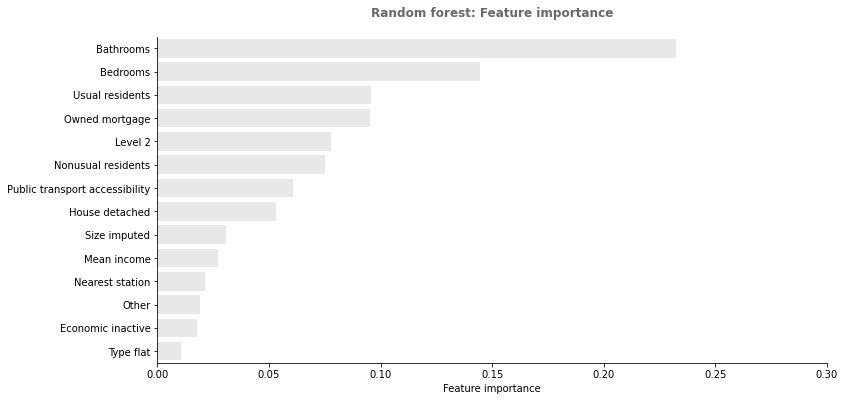

In [28]:
#Visualizing feature importance
#Preparing data
coefs = pd.DataFrame({"coefficient": list(rf_model.featureImportances), "column": relevant_coef_features}).sort_values(by = "coefficient", ascending = False)
coefs = coefs[coefs["coefficient"] > 0.01]
labels = [name.replace("_"," ").capitalize() for name in coefs["column"]]

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12,6), ncols = 1, nrows = 1)
sns.despine(top = True)

#Plotting
plot = sns.barplot(y = coefs["column"],
                   x = coefs["coefficient"],
                   ax = ax,
                   color = "#E8E8E8")
plot.set_title("Random forest: Feature importance",
               color = "#696969",
               weight = "bold",
               size = 12, 
               pad = 20)

#Setting parameters
plot.set_xlim(0,0.3)
plot.set_xlabel("Feature importance")
plot.set_yticklabels(labels, rotation = 0)
plot.set_ylabel("")

plt.show();

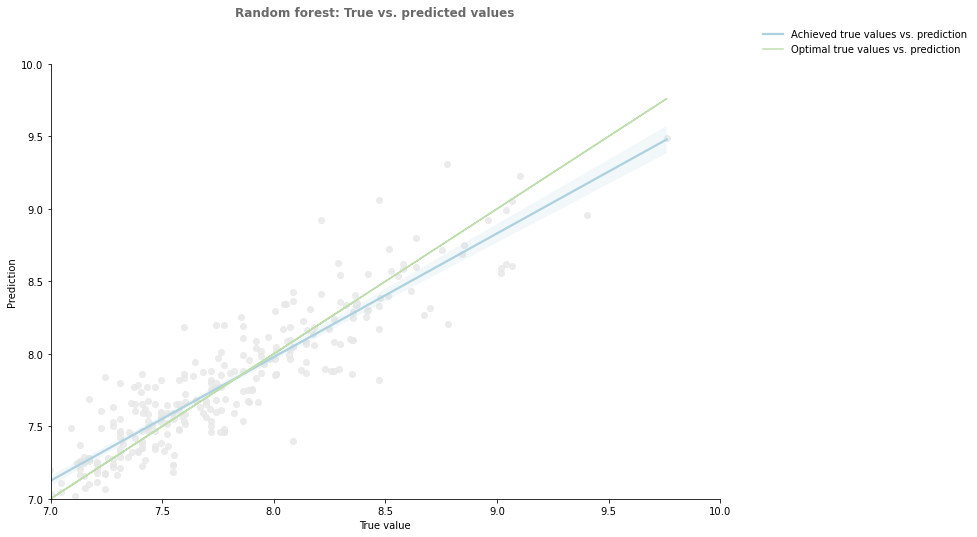

In [29]:
#Visualizing true vs. predicted values
#Preparing data
y_true = predictions.select("price").toPandas()
y_pred = predictions.select("prediction").toPandas()

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 8), ncols = 1, nrows = 1)
sns.despine(top = True)
fig.suptitle("Random forest: True vs. predicted values",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
error_plt = sns.regplot(
    x = y_true,
    y = y_pred,
    ax = ax, 
    color = "#E8E8E8",
    line_kws = {"color" : "#add1de"})

error_plt.plot(y_true, y_true, color = "#bfdead", linewidth = 1.5)

#Setting parameters
error_plt.set_ylim([7,10])
error_plt.set_xlim([7,10])
error_plt.set_xlabel("True value")
error_plt.set_ylabel("Prediction")
error_plt.legend(["Achieved true values vs. prediction", "Optimal true values vs. prediction"],
                 loc = "upper left", bbox_to_anchor = (1.05, 1.1, 0, 0), 
                 frameon = False)

plt.show();